In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 5
import numpy as np
np.random.seed(0)
from pyha import *
import scipy
from scipy import signal

import warnings
warnings.filterwarnings('ignore') # because they include system path -> fails unit tests on different computer

simulations = ['MODEL', 'PYHA']

# Application

In [3]:
from pyha.cores import Spectrogram
from pyha.cores.util import *
plt.rcParams['figure.figsize'] = 15, 5

In [4]:
fft_size = 1024
avg_freq_axis = 8
avg_time_axis = 2

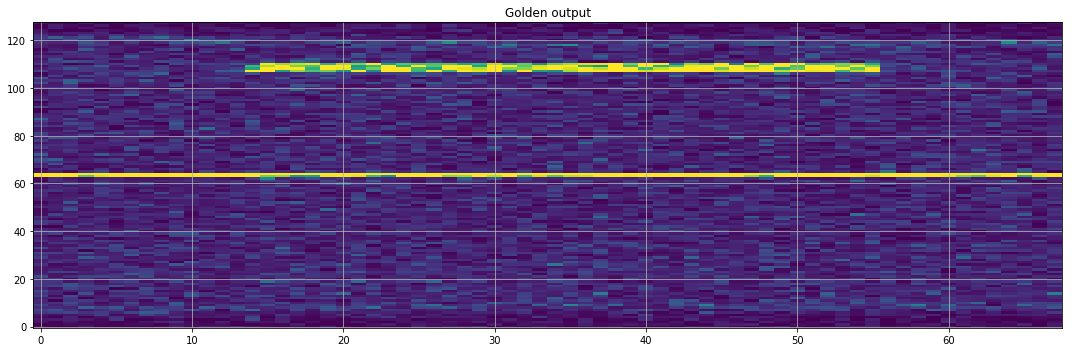

In [5]:
from scipy import signal
file = '/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq'
file = '/home/gaspar/git/pyha/pyha/cores/fft/bitreversal_fftshift_avgpool/phantom3_low_power_bladerf.npy'
# Note: sample count must be divisible with fft_size!
# orig_inp = load_iq(file)[10000:12048]
orig_inp = np.load(file)
orig_inp = orig_inp[:int(len(orig_inp)/fft_size)*fft_size] * 128

golden_output = Spectrogram(fft_size, avg_freq_axis, avg_time_axis).model_main(orig_inp)

plt.title('Golden output')
imshow(golden_output.T)

# DC Removal

In [6]:
# NBVAL_IGNORE_OUTPUT
from pyha.cores import DCRemoval
dut = DCRemoval(256, dtype=Complex)
sims0 = simulate(dut, orig_inp, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139265/139265 [00:15<00:00, 9026.97it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [7]:
snr(sims0['MODEL'], sims0['PYHA'])

70.52923853827991

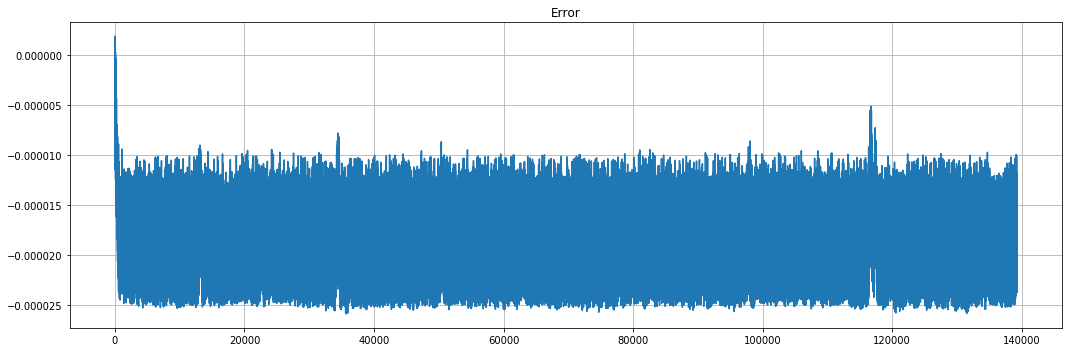

In [8]:
plt.title('Error')
plt.plot(sims0['MODEL'] - sims0['PYHA'])
show_plot()

# Packager

In [9]:
from pyha.cores import Packager
dut = Packager(fft_size)
sims1 = simulate(dut, orig_inp, simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139265/139265 [00:04<00:00, 31074.44it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [10]:
snr(sims1['MODEL'], sims1['PYHA'])

91.05001780154161

# Windower

In [11]:
from pyha.cores import Windower
dut = Windower(fft_size, coefficient_bits=18)
sims2 = simulate(dut, sims1['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139265/139265 [00:05<00:00, 25824.21it/s]

INFO:sim:OK!


INFO:sim:Simulations completed!


In [12]:
snr(sims2['MODEL'], sims2['PYHA'])

81.57608857429268

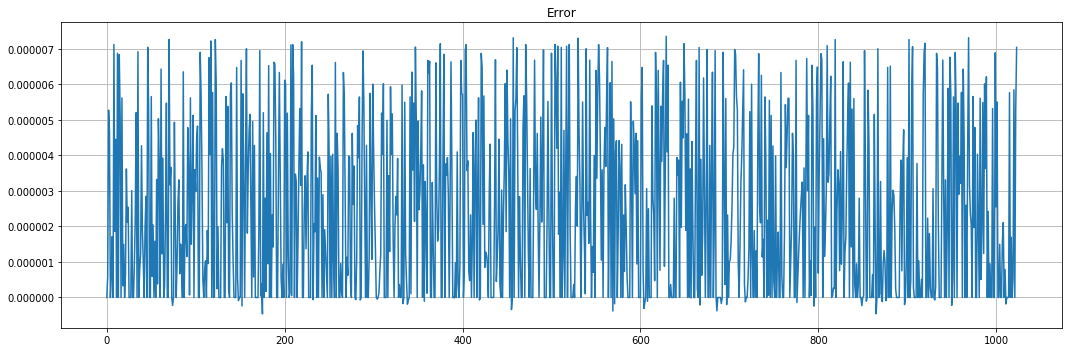

In [13]:
plt.title('Error')
plt.plot(sims2['MODEL'][0] - sims2['PYHA'][0])
show_plot()

# FFT

In [14]:
from pyha.cores import R2SDF
dut = R2SDF(fft_size, twiddle_bits=18)
sims3 = simulate(dut, sims2['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 140318/140318 [01:09<00:00, 2007.63it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [15]:
snr(sims3['MODEL'], sims3['PYHA'])

51.20055742730608

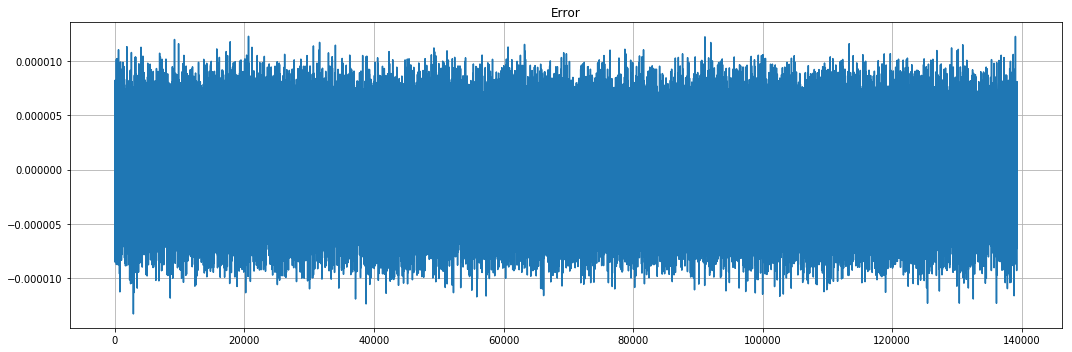

In [16]:
plt.title('Error')
plt.plot(sims3['MODEL'].flatten() - sims3['PYHA'].flatten())
show_plot()

# FFT to power

In [17]:
from pyha.cores import FFTPower
dut = FFTPower()
sims4 = simulate(dut, sims3['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 139265/139265 [00:05<00:00, 27252.16it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [18]:
snr(sims4['MODEL'], sims4['PYHA'])

inf

# Bitrverse, FFTShift, AVGPool

In [19]:
from pyha.cores import BitreversalFFTshiftAVGPool
dut = BitreversalFFTshiftAVGPool(fft_size, avg_freq_axis, avg_time_axis)
sims5 = simulate(dut, sims4['PYHA'], simulations=simulations)

INFO:sim:Converting model to hardware types ...
INFO:sim:Enabled fast simulation (model cannot be converted to VHDL)
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 140289/140289 [00:04<00:00, 34339.35it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


In [26]:
snr(golden_output, sims5['PYHA'])

61.600091424631216

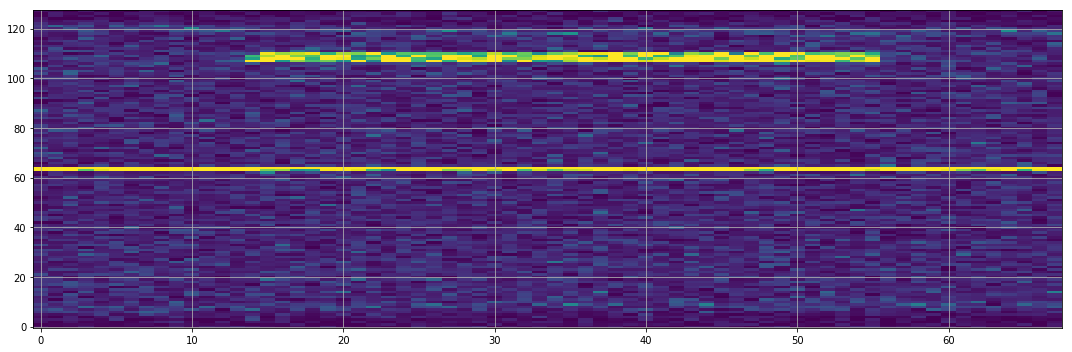

In [27]:
imshow(golden_output.T)

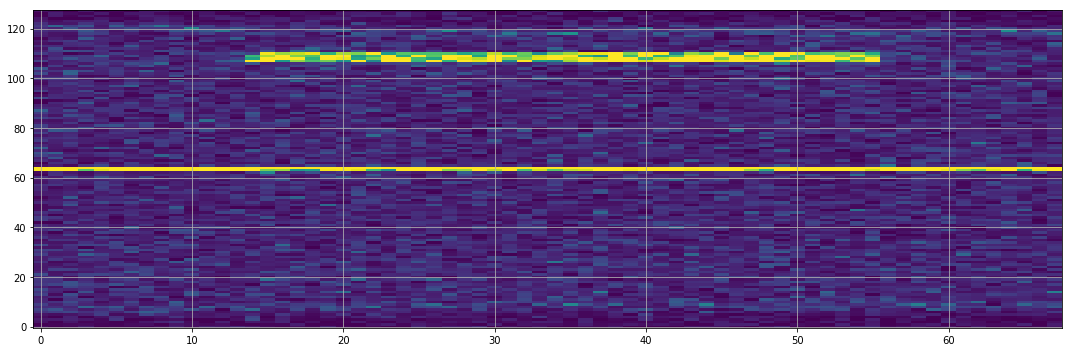

In [28]:
imshow(sims5['PYHA'].T)

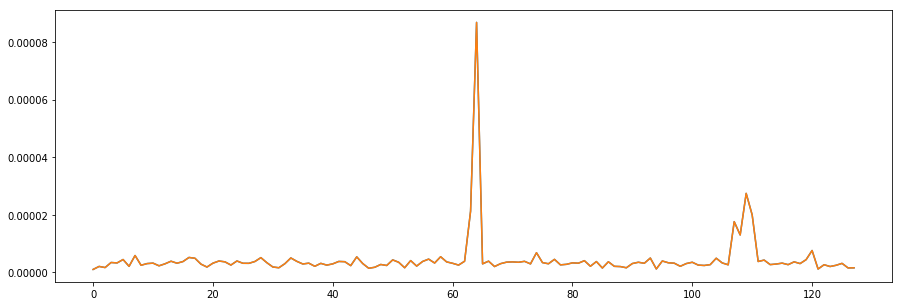

In [29]:
plt.plot(golden_output[40])
plt.plot(sims5['PYHA'][40])
plt.show()

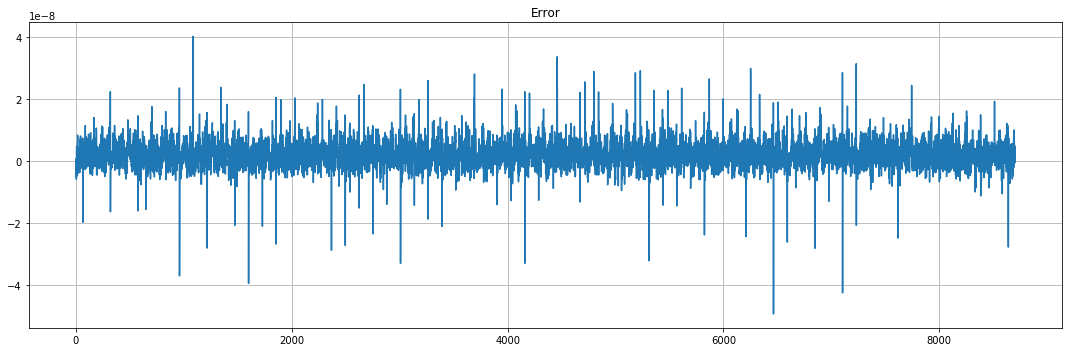

In [31]:
plt.title('Error')
plt.plot(golden_output.flatten() - sims5['PYHA'].flatten())
show_plot()